---
title: House Prices: Advanced Regression Techniques
date: 2019-05-28
tags: [Kaggle]
categories: [Kaggle]
---

Kaggle Competition 的练习

[房价预测](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [0]:
# 数据分析库
import pandas as pd
import numpy as np
import random

# 数据可视化
import seaborn as sns
import matplotlib.pyplot as plt

# 机器学习库
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

pd.options.display.max_rows = 10  # 最大显示行数
pd.options.display.float_format = '{:.5f}'.format  # 精确度 保留一位小数

In [0]:
train_df = pd.read_csv('/train.csv')
test_df = pd.read_csv('/test.csv')
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [0]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
# test_df.head()

In [0]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00000,1460.00000,1201.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1452.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1379.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000
mean,730.50000,56.89726,70.04996,10516.82808,6.09932,5.57534,1971.26781,1984.86575,103.68526,443.63973,46.54932,567.24041,1057.42945,1162.62671,346.99247,5.84452,1515.46370,0.42534,0.05753,1.56507,0.38288,2.86644,1.04658,6.51781,0.61301,1978.50616,1.76712,472.98014,94.24452,46.66027,21.95411,3.40959,15.06096,2.75890,43.48904,6.32192,2007.81575,180921.19589
std,421.61001,42.30057,24.28475,9981.26493,1.38300,1.11280,30.20290,20.64541,181.06621,456.09809,161.31927,441.86696,438.70532,386.58774,436.52844,48.62308,525.48038,0.51891,0.23875,0.55092,0.50289,0.81578,0.22034,1.62539,0.64467,24.68972,0.74732,213.80484,125.33879,66.25603,61.11915,29.31733,55.75742,40.17731,496.12302,2.70363,1.32810,79442.50288
min,1.00000,20.00000,21.00000,1300.00000,1.00000,1.00000,1872.00000,1950.00000,0.00000,0.00000,0.00000,0.00000,0.00000,334.00000,0.00000,0.00000,334.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,0.00000,1900.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2006.00000,34900.00000
25%,365.75000,20.00000,59.00000,7553.50000,5.00000,5.00000,1954.00000,1967.00000,0.00000,0.00000,0.00000,223.00000,795.75000,882.00000,0.00000,0.00000,1129.50000,0.00000,0.00000,1.00000,0.00000,2.00000,1.00000,5.00000,0.00000,1961.00000,1.00000,334.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,2007.00000,129975.00000
50%,730.50000,50.00000,69.00000,9478.50000,6.00000,5.00000,1973.00000,1994.00000,0.00000,383.50000,0.00000,477.50000,991.50000,1087.00000,0.00000,0.00000,1464.00000,0.00000,0.00000,2.00000,0.00000,3.00000,1.00000,6.00000,1.00000,1980.00000,2.00000,480.00000,0.00000,25.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,2008.00000,163000.00000
75%,1095.25000,70.00000,80.00000,11601.50000,7.00000,6.00000,2000.00000,2004.00000,166.00000,712.25000,0.00000,808.00000,1298.25000,1391.25000,728.00000,0.00000,1776.75000,1.00000,0.00000,2.00000,1.00000,3.00000,1.00000,7.00000,1.00000,2002.00000,2.00000,576.00000,168.00000,68.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.00000,2009.00000,214000.00000
max,1460.00000,190.00000,313.00000,215245.00000,10.00000,9.00000,2010.00000,2010.00000,1600.00000,5644.00000,1474.00000,2336.00000,6110.00000,4692.00000,2065.00000,572.00000,5642.00000,3.00000,2.00000,3.00000,2.00000,8.00000,3.00000,14.00000,3.00000,2010.00000,4.00000,1418.00000,857.00000,547.00000,552.00000,508.00000,480.00000,738.00000,15500.00000,12.00000,2010.00000,755000.00000


In [0]:
# test_df.describe()

In [0]:
train_df.info()
print('_' * 50)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [0]:
train_df.describe(include="O")

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


# 分析概要

Feature | Status | Dispose 
:-: | :-: | :-: 
Alley | 缺失比较多 | 删除 
PoolQC | 只有七家有游泳池并且和 PoolArea 相关 | 先不填充 删除 
Fence | 栏杆质量只有20%的有 | 缺失的填充为没有
MiscFeature | 其他项目也只有好少的房子有 | 先不填充 删除 
FireplaceQu | 有一半家没有壁炉 | 填 0
Garagetype | 空代表没有 | 填 0
Garagefinish | 空代表没有 | 填 0
Garagequal | 空代表没有 | 填 0
Garagecond | 空代表没有 | 填 0
LotFrontage | 和物业相连的街道有1/3缺失 | 没想到太好的填充方法 删除 

# 整理 description 文件

数据描述文件记录了所有特征所代表的含义，其中许多特征是字符串，现在我们要整理为个字典，便于我们查询。

In [0]:
description_dict = {}
with open('/data_description.txt','r') as description:
    description_data = description.read()
    description.close()
    
description_data = description_data.split('\n')

In [0]:
for i in description_data:
    if ':' in i:
        key = i.split(':')[0]
        description_dict[key] = []
    elif i.split() and '       ' in i:
        value = i.split()[0]
        description_dict[key].append(value)

print(description_dict)

{'MSSubClass': ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190'], 'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'], 'LotFrontage': [], 'LotArea': [], 'Street': ['Grvl', 'Pave'], 'Alley': ['Grvl', 'Pave', 'NA'], 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'], 'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'], 'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'], 'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'], 'LandSlope': ['Gtl', 'Mod', 'Sev'], 'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'], 'Condition1': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'Condition2': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'BldgType': ['1Fam', '2FmCo

In [0]:
description_dict['FireplaceQu']

['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']

# 预处理

首先先删除一些确实较多和不太好填充的feature。

In [0]:
# 删除
train_df = train_df.drop(['Alley', 'PoolQC', 'MiscFeature', 'LotFrontage'], axis=1)
test_df = test_df.drop(['Alley', 'PoolQC', 'MiscFeature', 'LotFrontage'], axis=1)

## 处理 GarageYrBlt: Year garage was built

车库的年代，没有填充 0，改为 1900 年开始。

In [0]:
def preprocess_garage_year(dataset):
    dataset = dataset.fillna(1900)
    dataset -= 1900
    return dataset
    
train_df['GarageYrBlt'] = preprocess_garage_year(train_df['GarageYrBlt'])
test_df['GarageYrBlt'] = preprocess_garage_year(test_df['GarageYrBlt'])

## 处理 Electrical
Electrical: Electrical system

    SBrkr    Standard Circuit Breakers & Romex
    FuseA    Fuse Box over 60 AMP and all Romex wiring (Average) 
    FuseF    60 AMP Fuse Box and mostly Romex wiring (Fair)
    FuseP    60 AMP Fuse Box and mostly knob & tube wiring (poor)
    Mix  Mixed

In [0]:
freq_port = train_df.Electrical.dropna().mode()[0] # 返回出现次数最多的值（众数）
freq_port

'SBrkr'

In [0]:
def preprocess_garage_year(dataset):
    dataset = dataset.fillna(freq_port)
    return dataset
    
train_df['Electrical'] = preprocess_garage_year(train_df['Electrical'])
test_df['Electrical'] = preprocess_garage_year(test_df['Electrical'])

## 处理 MasVnrArea: Masonry veneer area in square feet

砖石饰面面积:砖石饰面面积(平方英尺)

缺失的不是太多（148），mean 103，众数（75%以上）为 0，还没想到太好的填充，先填个0试试吧。

In [0]:
train_df.MasVnrArea.describe()

count   1452.00000
mean     103.68526
std      181.06621
min        0.00000
25%        0.00000
50%        0.00000
75%      166.00000
max     1600.00000
Name: MasVnrArea, dtype: float64

In [0]:
def preprocess_masvararea(dataset):
    dataset = dataset.fillna(0)
    return dataset
    
train_df['MasVnrArea'] = preprocess_masvararea(train_df['MasVnrArea'])
test_df['MasVnrArea'] = preprocess_masvararea(test_df['MasVnrArea'])

## 处理 MasVnrType

MasVnrType: Masonry veneer type

    BrkCmn   Brick Common
    BrkFace  Brick Face
    CBlock   Cinder Block
    None None
    Stone    Stone
    
这个值很奇怪，不太明白这是什么，是没有好呢还是 Stone 好呢？

In [0]:
train_df.MasVnrType.dropna().mode()[0] # 返回出现次数最多的值（众数）

'None'

大多数都没有，那就把缺失值填为没有吧。

In [0]:
def preprocess_masvnrtype(dataset):
    dataset = dataset.fillna('None')
    return dataset
    
train_df['MasVnrType'] = preprocess_masvnrtype(train_df['MasVnrType'])
test_df['MasVnrType'] = preprocess_masvnrtype(test_df['MasVnrType'])

## 处理其他缺失 feature

需要填充缺失值和重编码。

根据 data description 把 字符串类型的 feature 重编码。

构造 feature 对应的 map

观察发现以下这些缺失我们可以填充，顺便重编码。

In [0]:
missing_value = ['Fence',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',]

In [0]:
def generate_map(map_list, end_index=1):
    d = {}
    j = len(map_list) - end_index
    for i in map_list:
        d[i] = j
        j -= 1
    return d

In [0]:
missing_map_dict = {}
for feature in missing_value:
    missing_map_dict[feature] = generate_map(description_dict[feature])

missing_map_dict

{'BsmtCond': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'NA': 0, 'Po': 1, 'TA': 3},
 'BsmtExposure': {'Av': 3, 'Gd': 4, 'Mn': 2, 'NA': 0, 'No': 1},
 'BsmtFinType1': {'ALQ': 5,
  'BLQ': 4,
  'GLQ': 6,
  'LwQ': 2,
  'NA': 0,
  'Rec': 3,
  'Unf': 1},
 'BsmtFinType2': {'ALQ': 5,
  'BLQ': 4,
  'GLQ': 6,
  'LwQ': 2,
  'NA': 0,
  'Rec': 3,
  'Unf': 1},
 'BsmtQual': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'NA': 0, 'Po': 1, 'TA': 3},
 'Fence': {'GdPrv': 4, 'GdWo': 2, 'MnPrv': 3, 'MnWw': 1, 'NA': 0},
 'FireplaceQu': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'NA': 0, 'Po': 1, 'TA': 3},
 'GarageCond': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'NA': 0, 'Po': 1, 'TA': 3},
 'GarageFinish': {'Fin': 3, 'NA': 0, 'RFn': 2, 'Unf': 1},
 'GarageQual': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'NA': 0, 'Po': 1, 'TA': 3},
 'GarageType': {'2Types': 6,
  'Attchd': 5,
  'Basment': 4,
  'BuiltIn': 3,
  'CarPort': 2,
  'Detchd': 1,
  'NA': 0}}

In [0]:
# 预处理 feature 把 str 转换为序列 
def preprocess_feature_strtoint(feature_df, feature_mapping, default=0):
    feature_df = feature_df.map(feature_mapping)
    feature_df = feature_df.fillna(default)
    return feature_df

In [0]:
def preprocess_feature(dataset):
    for feature in missing_value:
        dataset[feature] = preprocess_feature_strtoint(dataset[feature], missing_map_dict[feature])
    return dataset

In [0]:
train_df = preprocess_feature(train_df)
test_df = preprocess_feature(test_df)

检查训练集缺失值，已经没有了。

In [0]:
train_df[train_df.isnull().values==True]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


## 填充测试集

测试集还有许多缺失，先决定用众数填充。

In [0]:
test_df[test_df.isnull().values==True]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,1556,50,RL,10632,Pave,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.00000,TA,TA,BrkTil,4.00000,2.00000,1.00000,1.00000,0.00000,1.00000,0.00000,689.00000,689.00000,GasA,Gd,N,SBrkr,725,499,0,1224,0.00000,0.00000,1,1,3,1,NaN,6,Mod,0,0.00000,1.00000,17.00000,1.00000,1.00000,180.00000,2.00000,2.00000,N,0,0,248,0,0,0,0.00000,0,1,2010,COD,Normal
455,1916,30,NaN,21780,Grvl,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.00000,Fa,Fa,CBlock,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,GasA,TA,N,FuseA,810,0,0,810,0.00000,0.00000,1,0,1,1,TA,4,Min1,0,0.00000,1.00000,75.00000,1.00000,1.00000,280.00000,3.00000,3.00000,N,119,24,0,0,0,0,0.00000,0,3,2009,ConLD,Normal
455,1916,30,NaN,21780,Grvl,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.00000,Fa,Fa,CBlock,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,GasA,TA,N,FuseA,810,0,0,810,0.00000,0.00000,1,0,1,1,TA,4,Min1,0,0.00000,1.00000,75.00000,1.00000,1.00000,280.00000,3.00000,3.00000,N,119,24,0,0,0,0,0.00000,0,3,2009,ConLD,Normal
485,1946,20,RL,31220,Pave,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.00000,TA,TA,CBlock,3.00000,3.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1632.00000,1632.00000,GasA,TA,Y,FuseA,1474,0,0,1474,0.00000,0.00000,1,0,3,1,TA,7,Min2,2,4.00000,5.00000,52.00000,1.00000,2.00000,495.00000,3.00000,3.00000,Y,0,0,144,0,0,0,0.00000,750,5,2008,WD,Normal
660,2121,20,RM,5940,Pave,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.00000,TA,TA,PConc,0.00000,0.00000,0.00000,0.00000,nan,0.00000,nan,nan,nan,GasA,TA,Y,FuseA,896,0,0,896,nan,nan,1,0,2,1,TA,4,Typ,0,0.00000,1.00000,46.00000,1.00000,1.00000,280.00000,3.00000,3.00000,Y,0,0,0,0,0,0,3.00000,0,4,2008,ConLD,Abnorml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,2474,50,RM,10320,Pave,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.00000,Fa,Fa,CBlock,3.00000,2.00000,1.00000,1.00000,0.00000,1.00000,0.00000,771.00000,771.00000,GasA,Fa,Y,SBrkr,866,504,114,1484,0.00000,0.00000,2,0,3,1,TA,6,NaN,0,0.00000,1.00000,10.00000,1.00000,1.00000,264.00000,3.00000,2.00000,N,14,211,0,0,84,0,0.00000,0,9,2007,COD,Abnorml
1029,2490,20,RL,13770,Pave,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.00000,TA,TA,CBlock,3.00000,3.00000,2.00000,3.00000,190.00000,4.00000,873.00000,95.00000,1158.00000,GasA,TA,Y,SBrkr,1176,0,0,1176,1.00000,0.00000,1,0,3,1,TA,6,Typ,2,4.00000,5.00000,58.00000,1.00000,1.00000,303.00000,3.00000,3.00000,Y,0,0,0,0,0,0,0.00000,0,10,2007,NaN,Normal
1116,2577,70,RM,9060,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6

In [0]:
for i in test_df.columns.values.tolist():
    freq_port = test_df[i].dropna().mode()[0] # 返回出现次数最多的值（众数)
    test_df[i] = test_df[i].fillna(freq_port)

## 字符串类型 feature 重编码

处理完缺失值后观察下还有那些feature是字符串形式的。

In [0]:
train_df.describe(include="O")

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,6,5,2,5,4,7,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,GasA,Ex,Y,SBrkr,TA,Typ,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,872,906,1282,647,1428,741,1365,1335,735,1360,1340,1267,1198


目前还有以下的 feature 需要编码

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

In [0]:
feature = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']
for i in feature:
    print(set(train_df[i]))

{'RL', 'FV', 'C (all)', 'RM', 'RH'}
{'Grvl', 'Pave'}
{'IR2', 'Reg', 'IR3', 'IR1'}
{'Lvl', 'Low', 'HLS', 'Bnk'}
{'AllPub', 'NoSeWa'}
{'CulDSac', 'FR2', 'Corner', 'FR3', 'Inside'}
{'Gtl', 'Mod', 'Sev'}
{'BrDale', 'NoRidge', 'Blmngtn', 'Sawyer', 'NPkVill', 'NridgHt', 'SawyerW', 'Mitchel', 'OldTown', 'NWAmes', 'NAmes', 'Somerst', 'Veenker', 'SWISU', 'CollgCr', 'BrkSide', 'ClearCr', 'IDOTRR', 'Crawfor', 'StoneBr', 'Timber', 'Gilbert', 'Blueste', 'MeadowV', 'Edwards'}
{'Artery', 'PosN', 'PosA', 'Norm', 'RRNn', 'RRAe', 'RRNe', 'Feedr', 'RRAn'}
{'Artery', 'PosN', 'PosA', 'Norm', 'RRNn', 'RRAe', 'Feedr', 'RRAn'}
{'2fmCon', 'Duplex', 'Twnhs', 'TwnhsE', '1Fam'}
{'SFoyer', '1.5Fin', '2Story', '1.5Unf', '2.5Fin', '2.5Unf', '1Story', 'SLvl'}
{'Mansard', 'Shed', 'Gable', 'Flat', 'Gambrel', 'Hip'}
{'Roll', 'Metal', 'ClyTile', 'WdShngl', 'CompShg', 'Tar&Grv', 'Membran', 'WdShake'}
{'BrkFace', 'Plywood', 'MetalSd', 'Stucco', 'WdShing', 'CBlock', 'AsphShn', 'Stone', 'ImStucc', 'CemntBd', 'Wd Sdng', 'Viny

观察到这些 feature 即有优劣等级划分的，也有没有等级的，既然如此，把有等级区分的编码为序列，没有等级的使用独热码。

有等级的：

    MSZoning
    ExterQual
    ExterCond
    HeatingQC
    KitchenQual
    
其余的使用onehot编码。

In [0]:
order_feature_set ={'MSZoning',
'ExterQual',
'ExterCond',
'HeatingQC',
'KitchenQual',}

onehot_feature_set = set(feature) - order_feature_set

### Order 编码

In [0]:
def preprocess_order_feature(dataset):
    for i in order_feature_set:
        order_map = generate_map(description_dict[i], 0)
        dataset[i] = dataset[i].map(order_map)
        dataset[i] = dataset[i].fillna(0)
    return dataset

In [0]:
train_df = preprocess_order_feature(train_df)
test_df = preprocess_order_feature(test_df)

In [0]:
train_df.describe()

,Id,MSSubClass,MSZoning,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SalePrice
count,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000
mean,730.50000,56.89726,2.82534,10516.82808,6.09932,5.57534,1971.26781,1984.86575,103.11712,3.39589,3.08356,3.48904,2.93493,1.63014,3.54589,443.63973,1.24726,46.54932,567.24041,1057.42945,4.14521,1162.62671,346.99247,5.84452,1515.46370,0.42534,0.05753,1.56507,0.38288,2.86644,1.04658,3.51164,6.51781,0.61301,1.82534,3.51438,74.15068,1.71575,1.76712,472.98014,2.81027,2.80890,94.24452,46.66027,21.95411,3.40959,15.06096,2.75890,0.56575,43.48904,6.32192,2007.81575,180921.19589
std,421.61001,42.30057,1.02017,9981.26493,1.38300,1.11280,30.20290,20.64541,180.73137,0.57428,0.35105,0.87648,0.55216,1.06739,2.10778,456.09809,0.89233,161.31927,441.86696,438.70532,0.95950,386.58774,436.52844,48.62308,525.48038,0.51891,0.23875,0.55092,0.50289,0.81578,0.22034,0.66376,1.62539,0.64467,1.81088,1.93321,29.98205,0.89283,0.74732,213.80484,0.72290,0.71969,125.33879,66.25603,61.11915,29.31733,55.75742,40.17731,1.20448,496.12302,2.70363,1.32810,79442.50288
min,1.00000,20.00000,0.00000,1300.00000,1.00000,1.00000,1872.00000,1950.00000,0.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,334.00000,0.00000,0.00000,334.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2006.00000,34900.00000
25%,365.75000,20.00000,3.00000,7553.50000,5.00000,5.00000,1954.00000,1967.00000,0.00000,3.00000,3.00000,3.00000,3.00000,1.00000,1.00000,0.00000,1.00000,0.00000,223.00000,795.75000,3.00000,882.00000,0.00000,0.00000,1129.50000,0.00000,0.00000,1.00000,0.00000,2.00000,1.00000,3.00000,5.00000,0.00000,0.00000,1.00000,58.00000,1.00000,1.00000,334.50000,3.00000,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,2007.00000,129975.00000
50%,730.50000,50.00000,3.00000,9478.50000,6.00000,5.00000,1973.00000,1994.00000,0.00000,3.00000,3.00000,4.00000,3.00000,1.00000,4.00000,383.50000,1.00000,0.00000,477.50000,991.50000,5.00000,1087.00000,0.00000,0.00000,1464.00000,0.00000,0.00000,2.00000,0.00000,3.00000,1.00000,3.00000,6.00000,1.00000,2.00000,5.00000,77.00000,2.00000,2.00000,480.00000,3.00000,3.00000,0.00000,25.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,2008.00000,163000.00000
75%,1095.25000,70.00000,3.00000,11601.50000,7.00000,6.00000,2000.00000,2004.00000,164.25000,4.00000,3.00000,4.00000,3.00000,2.00000,6.00000,712.25000,1.00000,0.00000,808.00000,1298.25000,5.00000,1391.25000,728.00000,0.00000,1776.75000,1.00000,0.00000,2.00000,1.00000,3.00000,1.00000,4.00000,7.00000,1.00000,4.00000,5.00000,101.00000,2.00000,2.00000,576.00000,3.00000,3.00000,168.00000,68.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.00000,2009.00000,214000.00000
max,1460.00000,190.00000,6.00000,215245.00000,10.0000

### One hot 编码

In [0]:
train_df.shape, test_df.shape

((1460, 77), (1459, 76))

In [0]:
def preprocess_onehot_feature(dataset):
    dataset_len = len(dataset)
    result = pd.DataFrame()
    for i in onehot_feature_set:
        tmp_pd = pd.get_dummies(dataset[i], prefix=i, dtype=float)
        result = pd.concat([result, tmp_pd], axis=1)
    return result

In [0]:
train_onehot_df = preprocess_onehot_feature(train_df)
test_onehot_df = preprocess_onehot_feature(test_df)

In [0]:
print(train_onehot_df.shape, test_onehot_df.shape)
test_missing = set(train_onehot_df.columns.values.tolist()) - set(test_onehot_df.columns.values.tolist())
test_missing

(1460, 168) (1459, 153)


{'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_Mix',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'Heating_Floor',
 'Heating_OthW',
 'HouseStyle_2.5Fin',
 'RoofMatl_ClyTile',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Utilities_NoSeWa'}

又遇到个坑，测试集比训练集的情况少。

In [0]:
# 生成一个缺失的 dagafarm
test_missing_zeros = pd.Series(np.zeros(1459))
test_missing_fd = pd.DataFrame({k: test_missing_zeros for k in test_missing} )

# 把缺失的填进去
test_onehot_df = pd.concat([test_onehot_df, test_missing_fd], axis=1)

In [0]:
print(train_onehot_df.shape, test_onehot_df.shape)

(1460, 168) (1459, 168)


把 新 one hot 编码的 feature 添加到 原集合中，并删除原来的 feature

In [0]:
# 把one hot的feature添加到训练集和测试集
train_df = pd.concat([train_df, train_onehot_df], axis=1)
test_df = pd.concat([test_df, test_onehot_df], axis=1)

# 同步删除训练集和测试集中的原feature
train_df = train_df.drop(onehot_feature_set, axis=1)
test_df = test_df.drop(onehot_feature_set, axis=1)

In [0]:
train_df.describe()

,Id,MSSubClass,MSZoning,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,...,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn
count,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,...,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000
mean,730.50000,56.89726,2.82534,10516.82808,6.09932,5.57534,1971.26781,1984.86575,103.11712,3.39589,3.08356,3.48904,2.93493,1.63014,3.54589,443.63973,1.24726,46.54932,567.24041,1057.42945,4.14521,1162.62671,346.99247,5.84452,1515.46370,0.42534,0.05753,1.56507,0.38288,2.86644,1.04658,3.51164,6.51781,0.61301,1.82534,3.51438,74.15068,1.71575,1.76712,472.98014,...,0.03425,0.00068,0.04178,0.15205,0.00068,0.15068,0.07397,0.00137,0.01712,0.35274,0.14110,0.01781,0.00068,0.98219,0.00068,0.00068,0.00068,0.00753,0.00342,0.00411,0.06438,0.01849,0.00205,0.00068,0.91438,0.06918,0.00274,0.00822,0.01370,0.82055,0.08562,0.03288,0.05548,0.86301,0.00548,0.01301,0.00753,0.01781,0.00137,0.00342
std,421.61001,42.30057,1.02017,9981.26493,1.38300,1.11280,30.20290,20.64541,180.73137,0.57428,0.35105,0.87648,0.55216,1.06739,2.10778,456.09809,0.89233,161.31927,441.86696,438.70532,0.95950,386.58774,436.52844,48.62308,525.48038,0.51891,0.23875,0.55092,0.50289,0.81578,0.22034,0.66376,1.62539,0.64467,1.81088,1.93321,29.98205,0.89283,0.74732,213.80484,...,0.18192,0.02617,0.20016,0.35920,0.02617,0.35786,0.26182,0.03700,0.12978,0.47799,0.34824,0.13230,0.02617,0.13230,0.02617,0.02617,0.02617,0.08650,0.05844,0.06400,0.24552,0.13477,0.04530,0.02617,0.27989,0.25384,0.05229,0.09032,0.11628,0.38386,0.27989,0.17837,0.22899,0.34395,0.07385,0.11337,0.08650,0.13230,0.03700,0.05844
min,1.00000,20.00000,0.00000,1300.00000,1.00000,1.00000,1872.00000,1950.00000,0.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,334.00000,0.00000,0.00000,334.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 221 entries, Id to Condition1_RRNn
dtypes: float64(182), int64(39)
memory usage: 2.5 MB


终于处理完了，已经没有 object 类型的数据了。接下来就能建模了。

# 模型预测

In [0]:
train_df.sample(frac=1)
X_train = train_df.drop(['SalePrice', 'Id'], axis=1)
Y_train = train_df['SalePrice']
X_test = test_df.drop('Id', axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((1460, 219), (1460,), (1459, 219))

先用逻辑回归看看

In [0]:
X_train

,Id,MSSubClass,MSZoning,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,...,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn
0,1,60,3.00000,8450,7,5,2003,2003,196.00000,4,3,4.00000,3.00000,1.00000,6.00000,706,1.00000,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,0,0.00000,5.00000,103.00000,2.00000,2,548,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,2,20,3.00000,9600,6,8,1976,1976,0.00000,3,3,4.00000,3.00000,4.00000,5.00000,978,1.00000,0,284,1262,5,1262,0,0,1262,0,1,2,0,3,1,3,6,1,3.00000,5.00000,76.00000,2.00000,2,460,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,3,60,3.00000,11250,7,5,2001,2002,162.00000,4,3,4.00000,3.00000,2.00000,6.00000,486,1.00000,0,434,920,5,920,866,0,1786,1,0,2,1,3,1,4,6,1,3.00000,5.00000,101.00000,2.00000,2,608,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,4,70,3.00000,9550,7,5,1915,1970,0.00000,3,3,3.00000,4.00000,1.00000,5.00000,216,1.00000,0,540,756,4,961,756,0,1717,1,0,1,0,3,1,4,7,1,4.00000,1.00000,98.00000,1.00000,3,642,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,5,60,3.00000,14260,8,5,2000,2000,350.00000,4,3,4.00000,3.00000,3.00000,6.00000,655,1.00000,0,490,1145,5,1145,1053,0,2198,1,0,2,1,4,1,4,9,1,3.00000,5.00000,100.00000,2.00000,3,836,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [0]:
# 逻辑回归

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


90.55

In [0]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

100.0

In [0]:

X = X_train.loc[: 1000]
Y = Y_train.loc[: 1000]

X_t = X_train.loc[1000: ]
Y_t = Y_train.loc[1000: ]

logreg = RandomForestClassifier(n_estimators=100)
logreg.fit(X, Y)
pred = logreg.predict(X_t)


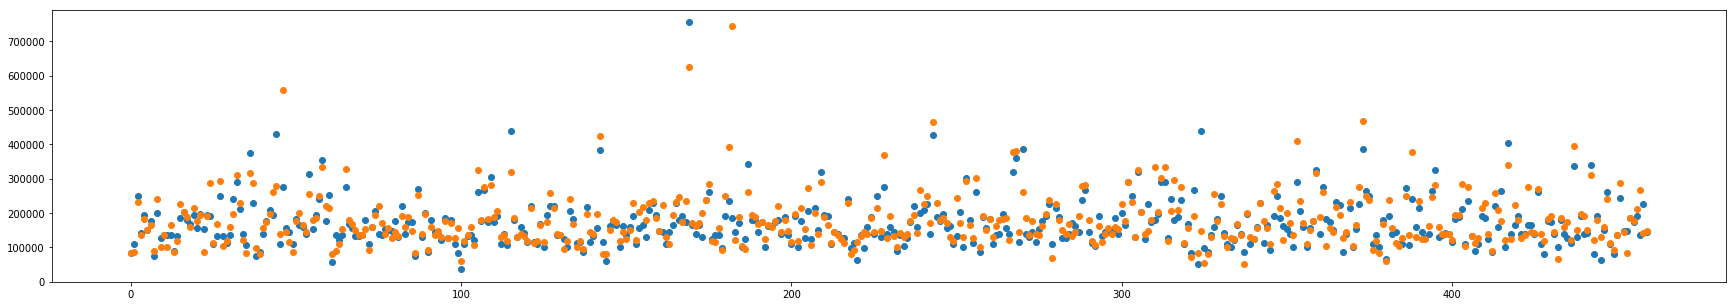

In [0]:
plt.figure(figsize=(30, 5))
x = np.array(range(len(pred)))
plt.scatter(x, pred)
plt.scatter(x, Y_t)
plt.show()

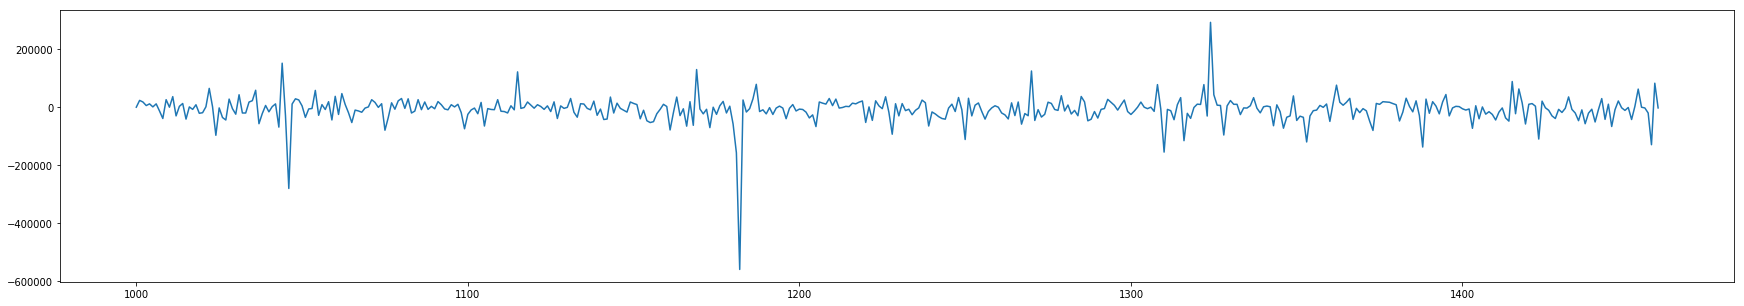

2231563230.032489

In [0]:
plt.figure(figsize=(30, 5))
plt.plot(pred - Y_t)
plt.show()
np.var(pred - Y_t)

In [0]:
np.array([range(len(pred))]*10).T

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [457, 457, 457, ..., 457, 457, 457],
       [458, 458, 458, ..., 458, 458, 458],
       [459, 459, 459, ..., 459, 459, 459]])

In [0]:
# Support Vector Machines

svm = SVC()
svm.fit(X_train, Y_train)
Y_pred = svm.predict(X_test)
acc_svm = round(svm.score(X_train, Y_train) * 100, 2)
acc_svm

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


99.52

In [0]:
# 保存结果

submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": Y_pred
    })
submission.to_csv("/submission.csv", index=False)
    